In [1]:
%%capture    
import os
os.environ['FIFTYONE_DATABASE_NAME'] = 'fiftyone-teams'
import fiftyone as fo
import fiftyone.core.storage as fos

import numpy as np
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt ## check to use PIL (low)
from tqdm import tqdm
from torchvision import datasets, transforms, models
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

CURRENT_DIR = os.getcwd()
#DATA_DIR = 'classification/Datasets/Clothes' 
DATA_DIR = 'classification/Datasets/ClothesModified'
#DATA_DIR = 'classification/Datasets/Data_Logo2K' 
#DATA_DIR =  'classification/Datasets/Dataset(1and2)/'
PATH_TO_YOLO = f'{CURRENT_DIR}/models/classification/yolo-best.pt'
#PATH_TO_RESNET =  f'{CURRENT_DIR}/classification/models/bestModels/bestModelResnet50None/resnet_best.pth'
PATH_TO_RESNET_last =  f'{CURRENT_DIR}/classification/models/2024-06-05_8:55/resnet_best.pth'
PATH_TO_RESNET_best = f'{CURRENT_DIR}/classification/models/Final/Adam(76)/Resnet50/best_model.pth' # best without cross
PATH_TO_RESNET = f'{CURRENT_DIR}/classification/models/2024-06-29_14:52/Resnet50/3/best_model.pth' # with cross_78%

#PATH_TO_RESNET =  'classification/models/acc95SmallSet/resnet_best.pth'
YOLO_MODEL = os.path.join(CURRENT_DIR, PATH_TO_YOLO)
YOLO_MODEL = os.path.join(CURRENT_DIR, PATH_TO_YOLO)
RESNET_MODEL = os.path.join(CURRENT_DIR, PATH_TO_RESNET)
print(RESNET_MODEL)

/home/jovyan/BA/classification/models/2024-06-29_14:52/Resnet50/3/best_model.pth


In [3]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()
classification_dir = os.path.join(current_dir, 'classification')
sys.path.append(classification_dir)

In [4]:
from classification.utilities import helper
from classification import engine
from classification import model_builder
from classification import train
from classification import data_setup
from classification.utilities.helper import save_model, create_directory_name, get_num_correct

In [5]:
train_dataset, valid_dataset, model_classes = data_setup.get_datasets(DATA_DIR)

[INFO]: Dataset loaded successfully.


In [6]:
num_classes = len(model_classes)
num_classes

297

In [7]:
import torch
import torch.nn as nn 
num_features = 2048
classifier =  nn.Sequential(
        #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(num_features, 1024),
            #nn.ReLU(),
            nn.BatchNorm1d(1024),
            #nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024, 512),
            #nn.ReLU(),
            nn.BatchNorm1d(512),
            #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(512, num_classes),
            #nn.ReLU(),
            nn.BatchNorm1d(num_classes),
            nn.Dropout(p=0.3, inplace=True)
        )

In [8]:
model = model_builder.create_resnet50(classifier=classifier, fine_tune=False, pretrained=True)

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...


In [9]:
dataset = datasets.ImageFolder(root=DATA_DIR, transform=None)
model_classes = dataset.classes

len(model_classes)

297

In [10]:
# Load the dataset from fiftyone
ds = fo.load_dataset("sellpy-test")

In [11]:
labels_to_filter = ['Women > Clothing','Kids > Clothing','Men > Clothing']
ds = ds.match({"lvl1.label": {"$in": labels_to_filter}})
print(ds)

Dataset:     sellpy-test
Media type:  image
Num samples: 204652
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    lvl0:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl1:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl2:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl3:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    size:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    color:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    fabric:         fiftyon

In [12]:
 x = ds.values("id")[:3]

In [13]:
np.array(x)[2]

'64c8b321f1e3091b5ec12394'

In [14]:
np.array(x)[[True,False,True]]

array(['64c8b321f1e3091b5ec1237e', '64c8b321f1e3091b5ec12394'],
      dtype='<U24')

In [15]:
ds.values('Grounding_Dino.detections.label')[100]

['mannequin', 'pocket', 'neck', 'arm', 'arm', 'zipper', 'zipper']

In [16]:
#limit = 10000
# get all ids
ds_temp = ds.match(fo.ViewField("Grounding_Dino") !=  None)
ids = ds_temp.values("id")
# check weather the sample contains a logo
contains_logo = ["logo" in values for values in ds_temp.values("Grounding_Dino.detections.label")]
# get ids of sample containing a logo 
ids_contains_logo = np.array(ids)[contains_logo]
# filter the data set to contain only samples with a logo found
ds_with_logos = ds[ids_contains_logo]
print(ds_with_logos)

Dataset:     sellpy-test
Media type:  image
Num samples: 37499
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    lvl0:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl1:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl2:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl3:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    size:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    color:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    fabric:         fiftyone

In [17]:
ds_with_logos.values("filepath")[0]

'minio://sellpy-images-pipeline/yQqYbiYZaD-irOWSZcGb0-c6ae-0.jpg'

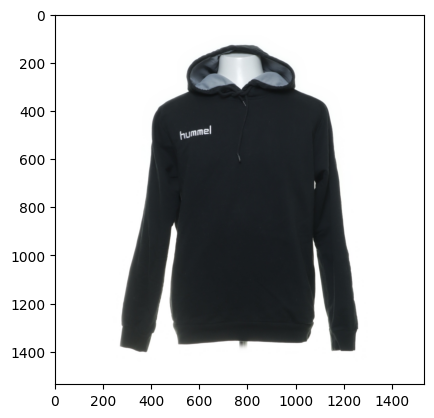

In [18]:
img = fo.utils.image.read('minio://sellpy-images-pipeline/yQqYbiYZaD-irOWSZcGb0-c6ae-0.jpg')
plt.imshow(img)

In [19]:
gt_field='brand'

In [20]:
all_brands = ds_with_logos.distinct("%s.label" % gt_field)
print(len(all_brands))

5176


In [21]:
ds_with_logos.values("Grounding_Dino.detections.label")[0]

['mannequin', 'hood', 'logo', 'arm', 'arm', 'zipper', 'zipper']

In [22]:
sample = ds_with_logos.first()
sample2 = ds_with_logos['64c8b338f1e3091b5ec20039']
sample3 = ds_with_logos['64c8b32ff1e3091b5ec17cff']
sample4 = ds_with_logos['64c8b326f1e3091b5ec13078']

In [23]:
sample = ds_with_logos['64c8b321f1e3091b5ec12628']

KeyError: "No sample found with ID '64c8b321f1e3091b5ec12628'"

In [27]:
len(ds_with_logos.values('brand.label'))

37499

# Filter Fiftyone Dataset

In [28]:
# get all brand labels 
brand_values = ds_with_logos.count_values("brand.label")
brands=list(brand_values.keys())
len(brands)

5176

In [29]:
brands.index("Zara")

4430

In [30]:
'None' in brands

True

In [31]:
import re
def normalize_brands(brand_list):
    normalized = []
    for brand in brand_list:
        # Umwandlung in Kleinbuchstaben
        brand = brand.lower()
        # Entfernen aller Wörter nach dem ersten
        #clean_brand = re.sub(r'\s.*', '', brand)
        normalized.append(brand)
    return normalized

class_names = normalize_brands(model_classes)
brands_ubber = normalize_brands(brands)
matches = set(class_names).intersection(set(brands_ubber))

print(f'Total brands: {len(brands)}')
print(f'Garments-brands: {len(class_names)}')

print(f'Total images: {sum(brand_values.values())}')
# Check if there are any matches
if matches:
    print("Matches found:", len(matches))
else:
    print("No matches found.")
model_fiftyone_labels_map = {brands[brands_ubber.index(b)]:class_names.index(b) for b in matches}

idx = [brands_ubber.index(b) for b in matches]
result_dict = {brands[key]:brand_values[brands[key]] for key in idx}
print(result_dict)
print(f'Total number of images for match brands: {sum(result_dict.values())}')
print('...............................................')

Total brands: 5176
Garments-brands: 297
Total images: 37499
Matches found: 70
{'Imperial': 1, 'Buffalo': 3, 'Salewa': 4, 'Springfield': 3, 'Dolce & Gabbana': 3, 'Reef': 1, 'Zara': 751, 'Svea': 30, 'Gap': 62, 'Detroit': 1, 'Cat': 1, 'Tommy Hilfiger': 366, 'Adidas': 1909, 'Fusion': 5, "Victoria's Secret": 40, 'Always': 8, 'MP': 6, 'Triumph': 25, 'C&A': 39, 'Element': 7, 'Dixie': 1, 'Roxy': 15, 'None': 877, 'Ellesse': 87, 'Lacoste': 57, 'Mizuno': 3, 'Arena': 7, 'And1': 2, 'Bounce': 1, 'Next': 55, 'Trespass': 3, 'Ed Hardy': 6, 'Zoggs': 3, 'Calvin Klein': 149, 'Star Wars': 30, 'Disney Pixar': 8, 'Hanes': 9, 'Burberry': 8, 'Speedo': 7, 'Nautica': 1, 'Pineapple': 1, 'Columbia': 18, 'Hummel': 93, 'Puma': 353, 'Nike': 1103, 'Vans': 105, 'Morgan': 4, 'Emilio': 5, 'La Perla': 1, 'Geox': 2, 'Batman': 7, 'G-Star': 8, 'H&M': 2435, 'Zoo York': 3, 'Sloggi': 8, 'Saucony': 10, 'Escada': 5, 'Fox': 4, 'Diesel': 79, 'Desigual': 190, 'Reebok': 99, 'Everlast': 4, 'Nickelodeon': 11, 'CCM': 10, 'Chicago': 1, '

In [32]:
result_dict['Zara']

751

In [33]:
result_dict['Tommy Hilfiger']

366

In [34]:
print(list(result_dict.keys()))

['Imperial', 'Buffalo', 'Salewa', 'Springfield', 'Dolce & Gabbana', 'Reef', 'Zara', 'Svea', 'Gap', 'Detroit', 'Cat', 'Tommy Hilfiger', 'Adidas', 'Fusion', "Victoria's Secret", 'Always', 'MP', 'Triumph', 'C&A', 'Element', 'Dixie', 'Roxy', 'None', 'Ellesse', 'Lacoste', 'Mizuno', 'Arena', 'And1', 'Bounce', 'Next', 'Trespass', 'Ed Hardy', 'Zoggs', 'Calvin Klein', 'Star Wars', 'Disney Pixar', 'Hanes', 'Burberry', 'Speedo', 'Nautica', 'Pineapple', 'Columbia', 'Hummel', 'Puma', 'Nike', 'Vans', 'Morgan', 'Emilio', 'La Perla', 'Geox', 'Batman', 'G-Star', 'H&M', 'Zoo York', 'Sloggi', 'Saucony', 'Escada', 'Fox', 'Diesel', 'Desigual', 'Reebok', 'Everlast', 'Nickelodeon', 'CCM', 'Chicago', 'Boss', 'Hurley', 'Givova', 'Russell', 'Los Angeles']


In [35]:
class_names[0]

'a. fernandez'

In [36]:
#model_fiftyone_labels_map

# This Function to delete none from the dictionary

In [37]:
def get_dict_without_key(dictionary, key):
    """Returns a copy of the dictionary without a key."""
    _dict = dictionary.copy()
    _dict.pop(key, None)
    return _dict

In [38]:
#result['None']

In [39]:
result = get_dict_without_key(model_fiftyone_labels_map, 'Zara')
result = get_dict_without_key(result, 'H&M')
result = get_dict_without_key(result, 'None')

In [40]:
len(model_fiftyone_labels_map)

70

In [41]:
len(result)

67

In [42]:
'None' in result.keys()

False

In [ ]:
def plot_data2_distribution(result):
    sorted_result = dict(sorted(result.items()))

    x = sorted_result.keys()
    y = sorted_result.values()

    plt.hist(y)
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.bar(x, y)
    plt.xlabel('Brand Name')
    plt.ylabel('Number of Images')
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    plt.grid(False)  # Disable grid for better readability
    plt.tight_layout()
    plt.savefig("BA/evaluation/Best/Data_Distribution.png")
    plt.show()

In [ ]:
result_dict['Adidas']

In [45]:
dataset_model_classes = ds_with_logos.match(fo.ViewField("brand.label").is_in(result.keys()))

In [46]:
result = dataset_model_classes.count_values("brand.label")
sum(result.values())

5109

In [47]:
model_fiftyone_labels_map['None']

211

In [48]:
brand_matches = list(result_dict.keys())

In [49]:
brand_matches[1]

'Buffalo'

In [50]:
model_classes.index('Pineapple')

232

In [51]:
model_classes[224]

'Paz'

In [52]:
import fiftyone as fo
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

# Load the CIFAR-10 dataset


# Define a custom dataset class
class FiftyOneDataset(Dataset):
    def __init__(
        self,
        fiftyone_dataset,
        model_fiftyone_labels_map,
        transforms=None,
        gt_field="Grounding_Dino",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.ids = self.samples.values("id")
        self.transforms = transforms
        self.gt_field = gt_field
        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct("brand.label")
        self.labels_map_rev = model_fiftyone_labels_map
        
    
        

    def __len__(self):
        return len(self.ids)
    
    def get_classes(self):
        return self.classes

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        sample = self.samples[img_id]
        metadata = sample.metadata
        img = fo.utils.image.read(sample.filepath)
        label = None
        for detection in sample.Grounding_Dino.detections:
            if detection.label=='logo' :#and detection.cnfidence>=0.20:
                label = sample.brand.label
                confidence = detection.cnfidence
                img = fo.utils.patches.extract_patch(img, detection)
                break #ToDo What if there is multiple boxes?
        img = Image.fromarray(img)
        
        if img is None:
            raise ValueError(f"Image at {sample.filepath} could not be read.")
        if self.transforms:
            img = self.transforms(img)

        if label is not None:
            label = torch.tensor(self.labels_map_rev[label])

        else:
             # Assign a default label if no valid detection is found (optional)
            label = torch.tensor(self.labels_map_rev['None'])  # Assuming -1 is a default class

        

        return img, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.RandomRotation(45),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(len(dataset_model_classes))
# Create a FiftyOneDataset instance
fo_dataset = FiftyOneDataset(dataset_model_classes, model_fiftyone_labels_map=model_fiftyone_labels_map, transforms=transform)

# Create a DataLoader
test_dataloader = DataLoader(fo_dataset, batch_size=32, shuffle=True, num_workers=2)
    # Process the outputs here


5109


In [53]:
len(model_fiftyone_labels_map)

70

In [54]:
model_fiftyone_labels_map

{'Imperial': 139,
 'Buffalo': 43,
 'Salewa': 248,
 'Springfield': 259,
 'Dolce & Gabbana': 79,
 'Reef': 242,
 'Zara': 292,
 'Svea': 265,
 'Gap': 109,
 'Detroit': 71,
 'Cat': 53,
 'Tommy Hilfiger': 275,
 'Adidas': 8,
 'Fusion': 104,
 "Victoria's Secret": 286,
 'Always': 12,
 'MP': 179,
 'Triumph': 279,
 'C&A': 45,
 'Element': 88,
 'Dixie': 77,
 'Roxy': 246,
 'None': 211,
 'Ellesse': 90,
 'Lacoste': 295,
 'Mizuno': 193,
 'Arena': 22,
 'And1': 5,
 'Bounce': 38,
 'Next': 203,
 'Trespass': 278,
 'Ed Hardy': 86,
 'Zoggs': 293,
 'Calvin Klein': 49,
 'Star Wars': 261,
 'Disney Pixar': 76,
 'Hanes': 124,
 'Burberry': 44,
 'Speedo': 258,
 'Nautica': 205,
 'Pineapple': 232,
 'Columbia': 61,
 'Hummel': 132,
 'Puma': 235,
 'Nike': 208,
 'Vans': 284,
 'Morgan': 197,
 'Emilio': 92,
 'La Perla': 156,
 'Geox': 111,
 'Batman': 28,
 'G-Star': 105,
 'H&M': 120,
 'Zoo York': 294,
 'Sloggi': 255,
 'Saucony': 250,
 'Escada': 95,
 'Fox': 101,
 'Diesel': 74,
 'Desigual': 70,
 'Reebok': 241,
 'Everlast': 98,
 '

In [55]:
len(fo_dataset.ids)

5109

In [56]:
#fo_dataset.classes

In [57]:
len(class_names)

297

In [58]:
#class_names.append('None')

In [59]:
#len(class_names)

In [60]:
#class_names[-1]

In [61]:
model_fiftyone_labels_map

{'Imperial': 139,
 'Buffalo': 43,
 'Salewa': 248,
 'Springfield': 259,
 'Dolce & Gabbana': 79,
 'Reef': 242,
 'Zara': 292,
 'Svea': 265,
 'Gap': 109,
 'Detroit': 71,
 'Cat': 53,
 'Tommy Hilfiger': 275,
 'Adidas': 8,
 'Fusion': 104,
 "Victoria's Secret": 286,
 'Always': 12,
 'MP': 179,
 'Triumph': 279,
 'C&A': 45,
 'Element': 88,
 'Dixie': 77,
 'Roxy': 246,
 'None': 211,
 'Ellesse': 90,
 'Lacoste': 295,
 'Mizuno': 193,
 'Arena': 22,
 'And1': 5,
 'Bounce': 38,
 'Next': 203,
 'Trespass': 278,
 'Ed Hardy': 86,
 'Zoggs': 293,
 'Calvin Klein': 49,
 'Star Wars': 261,
 'Disney Pixar': 76,
 'Hanes': 124,
 'Burberry': 44,
 'Speedo': 258,
 'Nautica': 205,
 'Pineapple': 232,
 'Columbia': 61,
 'Hummel': 132,
 'Puma': 235,
 'Nike': 208,
 'Vans': 284,
 'Morgan': 197,
 'Emilio': 92,
 'La Perla': 156,
 'Geox': 111,
 'Batman': 28,
 'G-Star': 105,
 'H&M': 120,
 'Zoo York': 294,
 'Sloggi': 255,
 'Saucony': 250,
 'Escada': 95,
 'Fox': 101,
 'Diesel': 74,
 'Desigual': 70,
 'Reebok': 241,
 'Everlast': 98,
 '

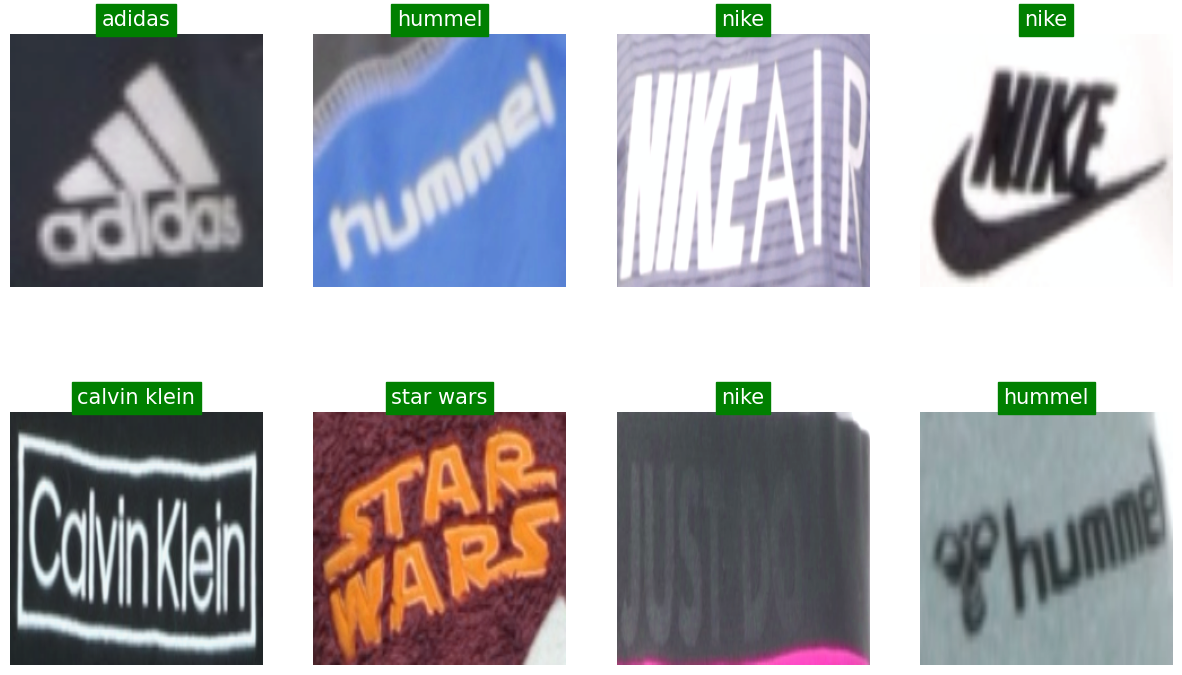

In [62]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(test_dataloader)
inputs, classes = next(iterator)
def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i-1]], ax)

plt.show()
fig.savefig('batch_images.png')

In [63]:
num_classes = len(class_names)
num_classes

297

img2 = fo.utils.image.read(sample2.get_local_path("filepath"))
print(sample2.brand.label)
plt.imshow(img2)
plt.show()


print(detections_logo[0]['bounding_box'])
for detection in detections_logo: 
    tile = fo.utils.patches.extract_patch(img, detection)
    plt.imshow(tile)
    plt.show()

# Test the classifier Model

# ultralytics==8.1.0
# https://pypi.org/project/ultralytics/8.1.39/
!pip install ultralytics==8.1.0

### YOLO MODEL

### RESNET

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from PIL import Image

In [65]:
import os

CURRENT_DIR = os.getcwd()
PATH_TO_RESNET_last =  f'{CURRENT_DIR}/classification/models/2024-06-05_8:55/resnet_best.pth'
PATH_TO_RESNET_best = f'{CURRENT_DIR}/classification/models/Final/Adam(76)/Resnet50/best_model.pth'
PATH_TO_RESNET = f'{CURRENT_DIR}/classification/models/2024-06-29_14:52/Resnet50/3/best_model.pth'

In [66]:
#from classification.model_builder import Resnet50, Resnet18

In [67]:
from classification import engine
from classification import train
from classification import data_setup
from classification import model_builder
from classification.utilities.helper import save_model, create_directory_name, get_num_correct

In [68]:
num_classes =len(model_classes)

In [69]:
import torch
import torch.nn as nn 
num_features = 2048
classifier =  nn.Sequential(
        #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(num_features, 1024),
            #nn.ReLU(),
            nn.BatchNorm1d(1024),
            #nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024, 512),
            #nn.ReLU(),
            nn.BatchNorm1d(512),
            #nn.Dropout(p=0.3, inplace=False),
            nn.Linear(512, num_classes),
            #nn.ReLU(),
            nn.BatchNorm1d(num_classes),
            nn.Dropout(p=0.3, inplace=True)
        )

In [70]:
model =  model_builder.create_resnet50(classifier=classifier, fine_tune=False, pretrained=True)

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...


In [71]:
import torch
from torchvision import models, transforms
from PIL import Image
print(num_classes)
#current_exp_dir = 'models/2024-04-24_8:59'
# Load the saved model with custom class number
#model =  Resnet18(num_classes=num_classes, pretrained=True, fine_tune=False)

 # Adjust final layer to number of classes 
PATH_TO_RESNET = f'{CURRENT_DIR}/classification/models/Final/Adam(76)/Resnet50/best_model.pth'
model.load_state_dict(torch.load(PATH_TO_RESNET))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.eval()

297


In [72]:
len(model_fiftyone_labels_map)

70

In [73]:
none_class_index = model_fiftyone_labels_map.get("None", -1)
none_class_index

211

## Idea for filter out misclassifications

In [74]:
model_fiftyone_labels_map_sorted = sorted(model_fiftyone_labels_map.items(), key=lambda x: x[1])    
model_fiftyone_labels_map_sorted

[('And1', 5),
 ('Adidas', 8),
 ('Always', 12),
 ('Arena', 22),
 ('Batman', 28),
 ('Boss', 37),
 ('Bounce', 38),
 ('Buffalo', 43),
 ('Burberry', 44),
 ('C&A', 45),
 ('CCM', 46),
 ('Calvin Klein', 49),
 ('Cat', 53),
 ('Chicago', 57),
 ('Columbia', 61),
 ('Desigual', 70),
 ('Detroit', 71),
 ('Diesel', 74),
 ('Disney Pixar', 76),
 ('Dixie', 77),
 ('Dolce & Gabbana', 79),
 ('Ed Hardy', 86),
 ('Element', 88),
 ('Ellesse', 90),
 ('Emilio', 92),
 ('Escada', 95),
 ('Everlast', 98),
 ('Fox', 101),
 ('Fusion', 104),
 ('G-Star', 105),
 ('Gap', 109),
 ('Geox', 111),
 ('Givova', 114),
 ('H&M', 120),
 ('Hanes', 124),
 ('Hummel', 132),
 ('Hurley', 134),
 ('Imperial', 139),
 ('La Perla', 156),
 ('Los Angeles', 170),
 ('MP', 179),
 ('Mizuno', 193),
 ('Morgan', 197),
 ('Next', 203),
 ('Nautica', 205),
 ('Nickelodeon', 207),
 ('Nike', 208),
 ('None', 211),
 ('Pineapple', 232),
 ('Puma', 235),
 ('Reebok', 241),
 ('Reef', 242),
 ('Roxy', 246),
 ('Russell', 247),
 ('Salewa', 248),
 ('Saucony', 250),
 ('Slogg

In [75]:
model_fiftyone_labels_map.get('None')

211

In [76]:
def save_image(tensor, filepath):
    tensor = tensor.cpu().detach().numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    tensor = tensor * std + mean
    tensor = np.clip(tensor, 0, 1)
    image = (tensor.transpose(1, 2, 0) * 255).astype('uint8')
    img = Image.fromarray(image)
    img.save(filepath)

In [77]:
def get_key_from_value(my_dict, value):
    for key, val in my_dict.items():
        if val == value:
            return key
    return None 

# For a list of models (Cross Validation)

# For one model

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from PIL import Image
from time import sleep
from tqdm import tqdm
import sys
import os
from sklearn.metrics import confusion_matrix, f1_score
from classification.utilities.helper import save_model, get_num_correct
def valid_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              model_fiftyone_labels_map,
                target_dir,
              device: torch.device):
    model.to(device)
    model.eval()
    save_dir = os.path.join(target_dir, "ClassifiedAsNone")
    os.makedirs(save_dir, exist_ok=True)
    reversed_dict = {v: k for k, v in model_fiftyone_labels_map.items()}
    #file_path = os.path.join(save_dir, f'{i}.png')
    print('Validation...')
    val_loss = 0.0
    val_corrects = 0
    total_valid_samples = 0
    misclassified_images = 0
    y_pred = []
    y_true = []
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Get the index for the "None" class
    none_class_index = model_fiftyone_labels_map.get("None", -1)
    with torch.no_grad():
        for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):        
            try:
                inputs = inputs.to(device)
                labels = labels.to(device)
            except AttributeError as e:
                print(f"Error processing batch {batch}: {e}")
                continue
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Filter out misclassifications where the model predicts "None" but true label is a brand
            condition = (preds == none_class_index) & (labels != none_class_index)
            valid_mask = ~(condition)
            filtered_preds = preds[valid_mask]
            filtered_labels = labels[valid_mask]
            filtered_outputs = outputs[valid_mask]

            # Calculate loss (per batch) only for valid detections
            if filtered_outputs.size(0) > 0:
                loss = loss_fn(filtered_outputs, filtered_labels)
                val_loss += loss.item() * filtered_outputs.size(0)
                total_valid_samples += filtered_outputs.size(0)

            # Calculate Accuracy
            val_corrects += get_num_correct(filtered_preds, filtered_labels)

            # Extend 
            y_pred.extend(filtered_preds.cpu().numpy())
            y_true.extend(filtered_labels.cpu().numpy())

            # Save images where the model predicted "None" but the true label is a brand
            misclassified_inputs = inputs[condition]
            misclassified_preds = preds[condition]
            misclassified_labels = labels[condition]
            misclassified_images += misclassified_inputs.size(0)

            for i in range(misclassified_inputs.size(0)):
                img_tensor = misclassified_inputs[i]
                pred_label = misclassified_preds[i].item()
                true_label = misclassified_labels[i].item()
                filepath = os.path.join(save_dir, f'batch_{batch}_img_{i}_pred_{reversed_dict[pred_label]}_true_{reversed_dict[true_label]}.png')
                save_image(img_tensor, filepath)

    avg_valid_loss = val_loss / total_valid_samples if total_valid_samples > 0 else 0
    avg_valid_acc = val_corrects / total_valid_samples * 100 if total_valid_samples > 0 else 0

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100
    print(f"[info]: Total valid Samples: {total_valid_samples}, Number of Samples classified as None: {misclassified_images}.")

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]

In [79]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [80]:
from classification.utilities.helper import save_model, create_target_dir

SAVE_TO = 'BA/evaluation'
target_dir =create_target_dir(SAVE_TO)

In [81]:
#len(models)

In [83]:
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]
y_pred = []
y_true = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
history_val = valid_model(model, test_dataloader, loss_fn, model_fiftyone_labels_map,target_dir, device)
        # Append result
y_pred.extend(history_val[2])
y_true.extend(history_val[3])

cuda:0
Validation...


100%|██████████| 160/160 [23:31<00:00,  8.82s/it]

[info]: Total valid Samples: 3659, Number of Samples classified as None: 1450.


In [84]:
history_val[1]

73.68133369773162

In [85]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [86]:
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
classificationReport = classification_report(y_true, y_pred)
with open(f'{target_dir}/classificationReport.txt', 'w') as file:
    file.write(f'Classification report:\n {classificationReport}')
    file.close()
    
print('Classification report: \n', classificationReport)

Accuracy on Validation set:  0.7368133369773162
Classification report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       1.00      0.87      0.93      1424
           9       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
        

In [87]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report = report[report['support'] != 0]
special_rows = report.loc[['accuracy', 'macro avg', 'weighted avg']]
report = report.drop(['accuracy', 'macro avg', 'weighted avg'])
report = report.sort_values(by='support', ascending=False)
report = report.append(special_rows)

#report = report.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)

print(report)
report.to_csv(f'{target_dir}/classification_report.csv', index=True)

              precision    recall  f1-score      support
8              0.999193  0.869382  0.929778  1424.000000
208            0.845304  0.806962  0.825688   948.000000
235            0.861660  0.798535  0.828897   273.000000
275            1.000000  0.082251  0.152000   231.000000
49             0.965517  0.500000  0.658824   112.000000
284            0.939759  0.886364  0.912281    88.000000
90             0.975610  0.963855  0.969697    83.000000
241            0.972973  0.500000  0.660550    72.000000
132            0.980392  0.746269  0.847458    67.000000
109            0.875000  0.792453  0.831683    53.000000
70             0.571429  0.170213  0.262295    47.000000
74             0.666667  0.187500  0.292683    32.000000
203            0.714286  0.250000  0.370370    20.000000
265            0.933333  0.777778  0.848485    18.000000
261            0.833333  0.555556  0.666667    18.000000
45             1.000000  0.062500  0.117647    16.000000
295            1.000000  0.3333

In [88]:
len(report)

59

In [89]:
with open(f'{target_dir}/classificationReportNoZeros.txt', 'w') as file:
    file.write(f'Classification report:\n {report}')
    file.close()

In [90]:
print('Weighted F1: {:.4f}'.format(history_val[4]))

Weighted F1: 78.5836


In [ ]:
class_names[275]

In [ ]:
len(class_names)

In [ ]:
result_dict['None']

In [ ]:
import re
def extract_support(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    pattern = re.compile(r'\s*(\d+)\s+[\d\.]+\s+[\d\.]+\s+[\d\.]+\s+(\d+)\s*')
    matches = pattern.findall(content)
    support_dict = {int(cls): int(support) for cls, support in matches}
    return support_dict
classificationReportPath = f'{target_dir}/classificationReport.txt'
report = extract_support(classificationReportPath)

In [ ]:
result_dict['Next']

In [ ]:
#report[203]

In [ ]:
result_dict['None']

In [ ]:
brand_loss = {}
for brand, cls in model_fiftyone_labels_map.items():
    number_of_images = result_dict.get(brand, 0)
    support = report.get(cls, 0)
    if cls not in report:
        loss = number_of_images
    else:
        loss = number_of_images - support
    brand_loss[brand] = f'Class:{cls} ,Total images: {number_of_images}, fed into model: {support}, loss: {loss}'

In [ ]:
def save_brand_loss(output_file_path):
    with open(output_file_path, 'w') as file:
        for brand, details in brand_loss.items():
            file.write(f'{brand}: {details}\n')

    print(f"Brand loss details saved to {output_file_path}")

output_file_path = f'{target_dir}/brand_loss.txt'
save_brand_loss(output_file_path)

In [ ]:
brand_loss

In [ ]:
def map_values_to_keys(keys_list, values_list):
    """
    This function takes a list `keys_list` and a list of `values_list`.
    It returns a list where each value in `values_list` maps to
    the corresponding keys in `keys_list`.
    """
    result = []
    for value in values_list:
        result.append(keys_list[value])
    return result

In [ ]:
label_to_name =  {value: key for key, value in model_fiftyone_labels_map.items()}
classes_of_interest = label_to_name.keys()

In [ ]:
label_to_name[284]

In [ ]:
# Build confusion matrix
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
# Verify lengths match
num_classes_matrix = cf_matrix.shape[0]
if len(class_names) != num_classes_matrix:
    print(f"Warning: Number of class names ({len(class_names)}) does not match the dimensions of the confusion matrix ({num_classes_matrix}). Adjusting class names list...")
    class_names_idx = sorted(list(set(y_true) | set(y_pred)))
    idx_to_class = map_values_to_keys(model_classes, class_names_idx)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in idx_to_class], columns = [i for i in idx_to_class])
else:
    idx_to_class = map_values_to_keys(model_classes, class_names)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in idx_to_class], columns = [i for i in idx_to_class])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for logos classification ")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(f'{target_dir}/Confusion_Matrix.png')
plt.show()

In [ ]:
class_names_idx.index(66)

In [ ]:
model_classes[149]

In [ ]:
class_names

In [ ]:
# Load and preprocess the unseen image
image_path = 'classification/img/000001.jpg'  # Replace with the path to your image
image = Image.open(image_path)
#preprocess = transforms.Compose([
#    transforms.Resize(224),
#    transforms.ToTensor(),
#    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#])
#input_tensor = preprocess(image)
#input_batch = input_tensor.unsqueeze(0)  

In [ ]:
# Load and preprocess the unseen image 
preprocess = transforms.Compose([
    transforms.Resize(224),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Map the predicted class to the class name
#class_names = ['Addidas', 'Diesel', 'Hummel']

In [ ]:
# Perform inference
model.eval()
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(1, 1, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("garments-brands.txt", "r") as file:
    lines = file.read().splitlines()
    
num_classes= len(lines)
garments_brands = lines
#print(lines)
print(f'{(num_classes)} Brands')

In [ ]:
# get all brand labels 
brand_values = ds_with_logos.count_values("brand.label")
brands=list(brand_values.keys())
len(brands)

In [89]:
import re
def normalize_brands(brand_list):
    normalized = []
    for brand in brand_list:
        # Umwandlung in Kleinbuchstaben
        brand = brand.lower()
        # Entfernen aller Wörter nach dem ersten
        clean_brand = re.sub(r'\s.*', '', brand)
        normalized.append(clean_brand)
    return normalized

class_names = normalize_brands(garments_brands)
brands_ubber = normalize_brands(brands)
matches = set(class_names).intersection(set(brands_ubber))

print(f'Total brands: {len(brands)}')
print(f'Garments-brands: {len(class_names)}')

print(f'Total images: {sum(brand_values.values())}')
# Check if there are any matches
if matches:
    print("Matches found:", len(matches))
else:
    print("No matches found.")
idx = [brands_ubber.index(b) for b in matches]
result_dict = {brands[key]:brand_values[brands[key]] for key in idx}
print(result_dict)
print(f'Total number of images for match brands: {sum(result_dict.values())}')
print('...............................................')

Total brands: 5177
Garments-brands: 286
Total images: 37507
Matches found: 91
{'Pro One': 1, 'Ed Hardy by Christian Audigier': 1, 'South West': 4, 'Nickelodeon': 11, 'Givova': 1, 'Buffalo David Bitton': 1, 'Globe Hope': 1, 'Batman': 7, 'Main Label': 2, 'Diana Orving': 3, 'Zoo York': 3, 'Vans': 105, 'Dolce & Gabbana Junior': 1, 'Victoria Beckham': 1, 'Trespass': 3, 'Ellesse': 87, 'Hurley': 2, 'La Maille Sézane': 1, 'Danish Design   ': 1, 'Comfort Colors': 2, 'Original Denim': 1, 'Miranda Konstantinidou': 1, 'Lewis Hamilton x Tommy Hilfiger': 1, 'Black Colour': 1, 'Life Line': 1, 'Burberry': 8, 'Peak Performance': 296, 'Saucony': 10, 'Springfield': 3, 'Limited Editon': 1, 'Big Fun': 1, 'Dixie': 1, 'Mizuno': 3, 'Zoggs': 3, 'Double a by Wood Wood': 3, 'Bounce': 1, 'Emilio Adani': 2, 'Club Wear Collection': 1, 'Fox': 4, 'Escada by Margaretha Ley': 1, 'Columbia Sportswear': 9, 'Fusion': 5, 'Disney Frozen ': 8, 'Lacoste': 57, 'Element': 7, 'Top Swede': 1, 'Mountain Warehouse': 1, 'Pineapple':

In [94]:
all_brans_ = list(result_dict.keys())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from time import sleep
from tqdm import tqdm
import sys
from sklearn.metrics import confusion_matrix, f1_score
from classification.utilities.helper import save_model, get_num_correct
def valid_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              model_fiftyone_labels_map,
              device: torch.device):
    model.to(device)
    model.eval()
    print('Validation...')
    val_loss = 0.0
    val_corrects = 0
    y_pred = []
    y_true = []
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        val_corrects += get_num_correct(preds, labels)
        
        # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    avg_valid_loss = val_loss / len(data_loader.dataset)
    avg_valid_acc = val_corrects / len(data_loader.dataset) * 100

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]